In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import scipy.stats as st

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


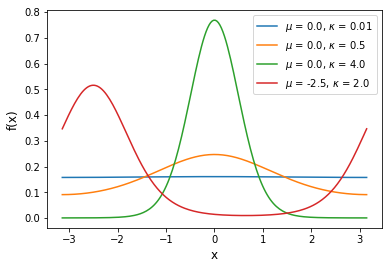

In [2]:
x = np.linspace(-np.pi, np.pi, 200)
mus = [0., 0., 0.,  -2.5]
kappas = [.01, 0.5,  4., 2.]
for mu, kappa in zip(mus, kappas):
    pdf = st.vonmises.pdf(x, kappa, loc=mu)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

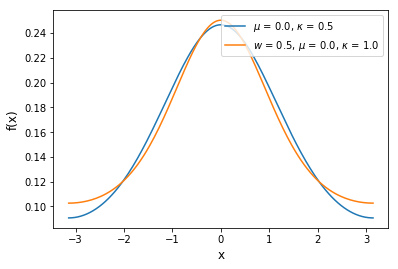

In [3]:
mu = 0.
kappa = 0.5
pdf = st.vonmises.pdf(x, kappa, loc=mu)
plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))

w = .5
mu = 0.
kappa = 1.
pdf = w*st.vonmises.pdf(x, kappa, loc=mu) + (1-w)*st.uniform.pdf(x, -np.pi, np.pi*2)
plt.plot(x, pdf, label=r'$w$ = {}, $\mu$ = {}, $\kappa$ = {}'.format(w, mu, kappa))

plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

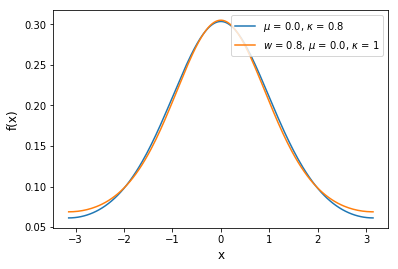

In [4]:
mu = 0.
kappa = .8
pdf = st.vonmises.pdf(x, kappa, loc=mu)
plt.plot(x, pdf, label=r'$\mu$ = {}, $\kappa$ = {}'.format(mu, kappa))

w = .8
mu = 0.
kappa = 1
pdf = w*st.vonmises.pdf(x, kappa, loc=mu) + (1-w)*st.uniform.pdf(x, -np.pi, np.pi*2)
plt.plot(x, pdf, label=r'$w$ = {}, $\mu$ = {}, $\kappa$ = {}'.format(w, mu, kappa))

plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1);

In [5]:
nsize = 200
w0 = .8
mu0 = 0.
kappa0 = 1
size1 = round(nsize*w)
size2 = nsize-size1
y = np.hstack([st.vonmises(kappa0, loc=mu0).rvs(size1), st.uniform(-np.pi, np.pi*2).rvs(size2)])

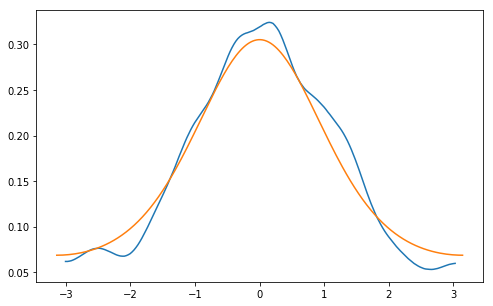

In [6]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))
pm.kdeplot(y, ax=ax)
pdf = w*st.vonmises.pdf(x, kappa0, loc=mu0) + (1-w0) * st.uniform.pdf(x, -np.pi, np.pi*2)
ax.plot(x, pdf, label=r'$w$ = {}, $\mu$ = {}, $\kappa$ = {}'.format(w, mu, kappa));

In [7]:
with pm.Model() as m1:
    mu = pm.Uniform('mu', -np.pi, np.pi)
    sd = pm.HalfFlat('sd')
    pm.VonMises('y', mu, kappa=sd, observed=y)
    tr1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, mu_interval__]
100%|██████████| 1000/1000 [00:01<00:00, 941.30it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '7636' (I am process '7637')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
The acceptance probability does not match the target. It is 0.8827188961867906, but should be close to 0.8. Try to increase the number of tuning steps.


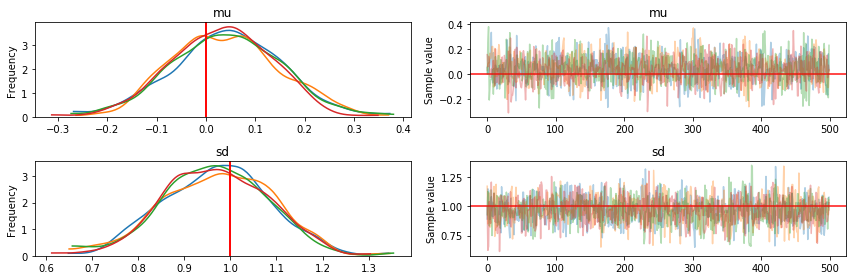

In [8]:
pm.traceplot(tr1, lines=dict(mu=mu0, sd=kappa0));

In [9]:
with pm.Model() as m2:
    mu = pm.Uniform('mu', -np.pi, np.pi)
    sd = pm.HalfFlat('sd')
    dist = [pm.Uniform.dist(-np.pi, np.pi),
            pm.VonMises.dist(mu, kappa=sd)]
    w = pm.Dirichlet('w', a=np.ones(2))
    pm.Mixture('y', w, dist, observed=y)
    tr2 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_stickbreaking__, sd_log__, mu_interval__]
100%|██████████| 1500/1500 [00:03<00:00, 399.69it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


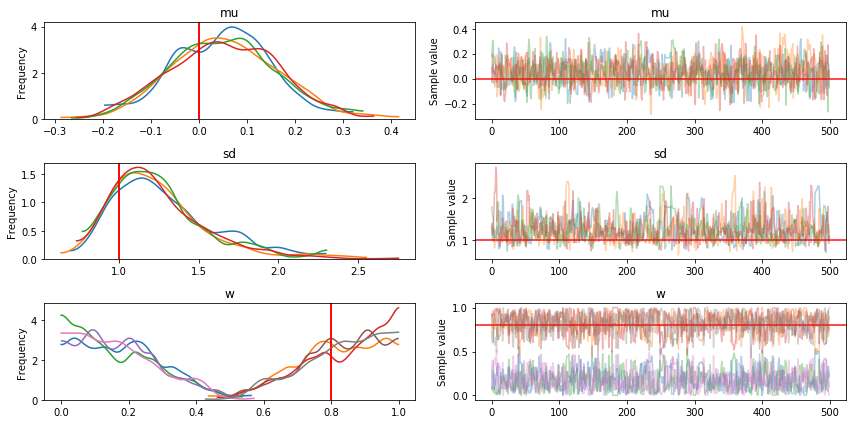

In [10]:
pm.traceplot(tr2, lines=dict(w=w0, mu=mu0, sd=kappa0));

In [11]:
pm.compare([tr1, tr2], [m1, m2])

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
0,659.19,1.92,0,1,16.23,0,0
1,660.87,2.24,1.68,0,15.76,1.36,0
